In [3]:
library(markovchain)
library(data.table)
library(ggplot2)
library(dplyr)
setwd("/home/pasoneto/Documents/Ciência/PhD")
options(warn=-1)


# The Markov playlister

Calculating transition probabilities from sequences of album tracks

In [4]:
S = sample(c('loud', 'medium', 'quiet'), replace = T, 10); S

[1] "medium" "quiet"  "medium" "medium" "quiet"  "loud"   "loud"   "medium"
 [9] "loud"   "quiet"

In [5]:
A = markovchainFit(data = S)$estimate@transitionMatrix; A

,loud,medium,quiet
loud,0.3333333,0.3333333,0.3333333
medium,0.2500000,0.2500000,0.5000000
quiet,0.5000000,0.5000000,0.0000000


# Playlist evaluator

Given an empirically derived transition matrix, how likely is the sequence below to occur?

- medium, medium, loud, medium, medium, quiet, loud, medium, quiet, medium

In [6]:
#new sequence S'
S_line = c("loud", "loud", "loud", 
           "medium", "medium", "loud", 
           "medium", "loud", "loud", "medium")

#original, used to derive A
S; S_line

[1] "medium" "quiet"  "medium" "medium" "quiet"  "loud"   "loud"   "medium"
 [9] "loud"   "quiet"

[1] "loud"   "loud"   "loud"   "medium" "medium" "loud"   "medium" "loud"  
 [9] "loud"   "medium"

Is it likely that $S'$ was built under our original transition matrix?


We can anwer it by evaluating if $\mathcal{L}(S|A)$ $>$ $\mathcal{L}(S'|A)$

The average Log Likelihood of a playlist $S$, given a playlister $A$, is written as 

$$\mathcal{L}(S|A) = \frac{1}{N_S} \sum log\ P[f_{i+1}|f_i]$$

Where $f_i$ represents the discrete feature $f$ of song $i$, and $N_S$ the length of playlist $S$. We take the average because $S$ might have different lengths.

We can also use the same sequence and different playlisters to compare $\mathcal{L}(S|A)$, $\mathcal{L}(S|A')$, $\mathcal{L}(S|A'')$, 

which essentially asks "which playlister is more likely to have generated sequence $S$? $A$, $A'$ or $A''$?" 



## Implementation

In [7]:
# arr: array com transições; mo: empirically derived markov object, returns log likelihood of arr
ll = function(mo, arr){ t <- log(transitionProbability(mo, arr[1], arr[2]))
                        return( if( length(arr) == 2 ) t else t + ll(mo, arr[2:length(arr)]) )}

# get the mean likelihood of playlist
mll = function(mo, arr){ return (ll(mo, arr)/length(arr)) }

# Comparing sequences under the same transition matrix

This shows that our original sequence was most likely built under our empirically derived transition matrix, and also that the new sequence B, was probably built under a different transition matrix.

In [7]:
A <- new("markovchain", states = c("loud", "medium", "quiet"),
     transitionMatrix = matrix(data = as.vector(t(A)),
                               byrow = TRUE, nrow = 3))

A_line <- new("markovchain", states = c("loud", "medium", "quiet"),
          transitionMatrix = matrix(data = c(1/3, 1/3, 1/3,
                                        1/3, 1/3, 1/3,
                                        1/3, 1/3, 1/3),
                               byrow = TRUE, nrow = 3))

#Sequence S is more likely to have occured than S_line
mll(A, S) > mll(A, S_line)

#Sequence S is more likely to have ocurred under A
mll(A, S) > mll(A_line, S)

[1] TRUE

[1] TRUE

# Empirical evaluation

Evaluating the same idea on our dataset. First we need to discreticize our features.

In [8]:
dt = fread("novo.csv")

dt %<>% select(!V1) %>% 
       group_by(album_id) %>% mutate(album_length = NROW(track_number)) %>%
       filter(track_number < 9) %>%
       select(album_id, track_number, valence, energy, loudness, tempo) %>%
       mutate(valence  = as.factor(rank(valence, na.last = "keep", ties.method = "random")), 
              energy   = as.factor(rank(energy, na.last = "keep", ties.method = "random")),
              loudness = as.factor(rank(loudness, na.last = "keep", ties.method = "random")),
              tempo    = as.factor(rank(tempo, na.last = "keep", ties.method = "random"))); dt

album_id,track_number,valence,energy,loudness,tempo
<chr>,<int>,<fct>,<fct>,<fct>,<fct>
008M3KxE8IO39sdTRFeZwn,1,1,8,7,6
008M3KxE8IO39sdTRFeZwn,2,7,4,3,2
008M3KxE8IO39sdTRFeZwn,3,4,2,8,1
008M3KxE8IO39sdTRFeZwn,4,2,3,2,4
008M3KxE8IO39sdTRFeZwn,5,5,5,4,8
008M3KxE8IO39sdTRFeZwn,6,6,7,6,3
008M3KxE8IO39sdTRFeZwn,7,3,1,1,7
008M3KxE8IO39sdTRFeZwn,8,8,6,5,5
009Y1z4EpUUubSmtf1jEl3,1,4,6,1,4


# Fitting the Markov Chain

First we separating between training and test.

In [9]:
dt = split(dt, dt$album_id)
size <- floor(0.75 * length(dt))

train_ind <- sample(seq_len(length(dt)), size = size)

dt_train <- dt[train_ind]
dt_test <- dt[-train_ind]

## Calculating transition matrices

As control, I randomly shuffled the tracks of each album and calculated a transition matrix from both the randomized and original versions. This would give me a different playlister $A'$ to compare with our empirically derived transition matrix.

In [10]:
valence = c(); energy = c() ;loudness = c(); tempo = c()
rv = c(); re = c() ; rl = c(); rt = c()
valence_t = c(); energy_t = c() ;loudness_t = c(); tempo_t = c()

for(i in 1:length(dt_train)){
  valence[[i]]  <- c('i', dt_train[[i]]$valence)
  energy[[i]]   <- c('i', dt_train[[i]]$energy)
  loudness[[i]] <- c('i', dt_train[[i]]$loudness)
  tempo[[i]]    <- c('i', dt_train[[i]]$tempo)
}

for(i in 1:length(dt_train)){
  rv[[i]]  <- c('i', sample(dt_train[[i]]$valence, replace = FALSE, size = length(dt_train[[i]]$valence)))
  re[[i]]   <- c('i', sample(dt_train[[i]]$energy, replace = FALSE, size = length(dt_train[[i]]$energy)))
  rl[[i]] <- c('i', sample(dt_train[[i]]$loudness, replace = FALSE, size = length(dt_train[[i]]$loudness)))
  rt[[i]]    <- c('i', sample(dt_train[[i]]$tempo, replace = FALSE, size = length(dt_train[[i]]$tempo)))
}

for(i in 1:length(dt_test)){
  valence_t[[i]]  <- c('i', dt_test[[i]]$valence)
  energy_t[[i]]   <- c('i', dt_test[[i]]$energy)
  loudness_t[[i]] <- c('i', dt_test[[i]]$loudness)
  tempo_t[[i]]    <- c('i', dt_test[[i]]$tempo)
}

# #Getting the transition
v = data.frame(markovchainFit(data = valence)$estimate@transitionMatrix)
e = data.frame(markovchainFit(data = energy)$estimate@transitionMatrix)
l = data.frame(markovchainFit(data = loudness)$estimate@transitionMatrix)
t = data.frame(markovchainFit(data = tempo)$estimate@transitionMatrix)

#creating the object
v <- new("markovchain", states = c("1", "2", "3", "4", "5", "6", "7", "8", "i"), transitionMatrix = matrix(data = as.vector(t(v)), byrow = TRUE, nrow = nrow(v)), name = "valence")
e <- new("markovchain", states = c("1", "2", "3", "4", "5", "6", "7", "8", "i"), transitionMatrix = matrix(data = as.vector(t(e)), byrow = TRUE, nrow = nrow(e)), name = "energy")
l <- new("markovchain", states = c("1", "2", "3", "4", "5", "6", "7", "8", "i"), transitionMatrix = matrix(data = as.vector(t(l)), byrow = TRUE, nrow = nrow(l)), name = "loudness")
t <- new("markovchain", states = c("1", "2", "3", "4", "5", "6", "7", "8", "i"), transitionMatrix = matrix(data = as.vector(t(t)), byrow = TRUE, nrow = nrow(t)), name = "tempo")

# creating a uniform distribution
# random <- new("markovchain", states = c("1", "2", "3", "4", "5", "6", "7", "8", "i"), transitionMatrix = matrix(data = c(1/5, 1/5, 1/5, 1/5, 1/5, 0, 1/5, 1/5, 1/5, 1/5, 1/5, 0, 1/5, 1/5, 1/5, 1/5, 1/5, 0, 1/5, 1/5, 1/5, 1/5, 1/5, 0, 1/5, 1/5, 1/5, 1/5, 1/5, 0, 1/5, 1/5, 1/5, 1/5, 1/5, 0), byrow = TRUE, nrow = nrow(t)), name = "random")

rv = data.frame(markovchainFit(data = rv)$estimate@transitionMatrix)
re = data.frame(markovchainFit(data = re)$estimate@transitionMatrix)
rl = data.frame(markovchainFit(data = rl)$estimate@transitionMatrix)
rt = data.frame(markovchainFit(data = rt)$estimate@transitionMatrix)

rv <- new("markovchain", states = c("1", "2", "3", "4", "5", "6", "7", "8", "i"), transitionMatrix = matrix(data = as.vector(t(rv)), byrow = TRUE, nrow = nrow(v)), name = "rvalence")
re <- new("markovchain", states = c("1", "2", "3", "4", "5", "6", "7", "8", "i"), transitionMatrix = matrix(data = as.vector(t(re)), byrow = TRUE, nrow = nrow(e)), name = "renergy")
rl <- new("markovchain", states = c("1", "2", "3", "4", "5", "6", "7", "8", "i"), transitionMatrix = matrix(data = as.vector(t(rl)), byrow = TRUE, nrow = nrow(l)), name = "rloudness")
rt <- new("markovchain", states = c("1", "2", "3", "4", "5", "6", "7", "8", "i"), transitionMatrix = matrix(data = as.vector(t(rt)), byrow = TRUE, nrow = nrow(t)), name = "rtempo")

In [11]:
for(j in 10){
  v_ll <- c(); e_ll <- c(); l_ll <- c(); t_ll <- c()
  
  r_v <- c(); r_e <- c(); r_l <- c(); r_t <- c()
  
  for(i in 1:length(valence_t)){
    v_ll[i] <- mll(v, valence_t[[i]])
    e_ll[i] <- mll(e, energy_t[[i]])
    l_ll[i] <- mll(l, loudness_t[[i]])
    t_ll[i] <- mll(t, tempo_t[[i]])
    
    r_v[i] <- mll(rv, valence_t[[i]])
    r_e[i] <- mll(re, energy_t[[i]])
    r_l[i] <- mll(rl, loudness_t[[i]])
    r_t[i] <- mll(rt, tempo_t[[i]])
  }
}

log_likelihoods <- 
  data.frame(empirical_valence = v_ll,
             empirical_energy = e_ll,
             empirical_loudness = l_ll,
             empirical_tempo = t_ll,
             
             random_valence = r_v,
             random_energy = r_e,
             random_loudness = r_l,
             random_tempo = r_t
  )

ll <-
  melt(data = log_likelihoods, 
       measure.vars = c('empirical_valence',
                        'empirical_energy',
                        'empirical_loudness',
                        'empirical_tempo',
                        'random_valence',
                        'random_energy',
                        'random_loudness',
                        'random_tempo')
  )

ll<- 
  tidyr::separate(ll, 
                  variable, 
                  c("condition", "feature"), 
                  "_")

teste <- plyr::ddply(ll, c('feature', 'condition'), plyr::summarise,
                     log_likelihood = mean(value),
                     se = sd(value)/sqrt(length(value))
)

# Results

In [12]:
teste

feature,condition,log_likelihood,se
<chr>,<chr>,<dbl>,<dbl>
energy,empirical,-1.741490,0.0008059214
energy,random,-1.741266,0.0007712063
loudness,empirical,-1.739663,0.0008532490
loudness,random,-1.740837,0.0007345395
tempo,empirical,-1.740950,0.0007829605
tempo,random,-1.741300,0.0007560253
valence,empirical,-1.739728,0.0007837072
valence,random,-1.740857,0.0007109333


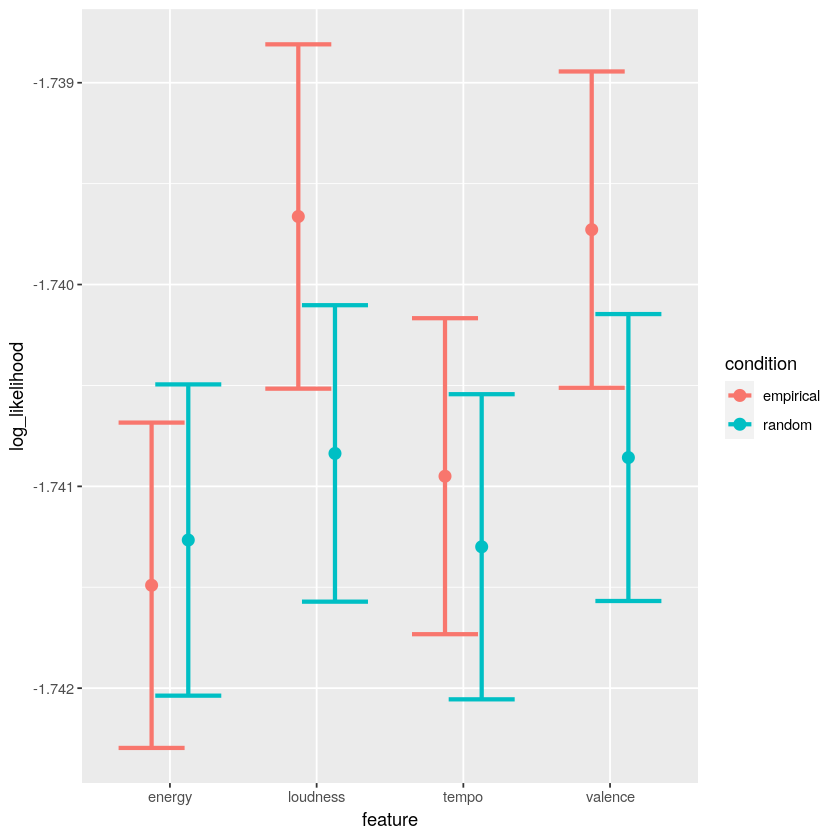

In [13]:
ggplot(teste, aes(x=feature, y=log_likelihood, color = condition)) +
  geom_errorbar(size = 1.2, aes(ymin=log_likelihood-se, ymax=log_likelihood+se), position=position_dodge(0.5)) +
  geom_point(size = 3, position=position_dodge(0.5), fill = 'black')

## Final analysis

Should we start from the top?

In [14]:
vv = v@transitionMatrix[v@transitionMatrix == 0] <- NA
ee = e@transitionMatrix[e@transitionMatrix == 0] <- NA
ll = l@transitionMatrix[l@transitionMatrix == 0] <- NA
tt = t@transitionMatrix[t@transitionMatrix == 0] <- NA

matpalette <- colorRampPalette(c("white", "red", "black"))(100)

vv = c(); ee = c(); ll = c(); tt = c()
for(i in 1:9){ vv = c(vv, v[9, i])
               ee = c(ee, e[9, i])
               ll = c(ll, l[9, i])
               tt = c(tt, t[9, i])}

In [15]:
probmatrix = 
  data.frame("rank" = c(1:8, "i"),
             "valence" = vv,
             "energy" = ee,
             "loudness" = ll,
             "tempo" = tt)

probmatrix = melt(probmatrix)

Using rank as id variables



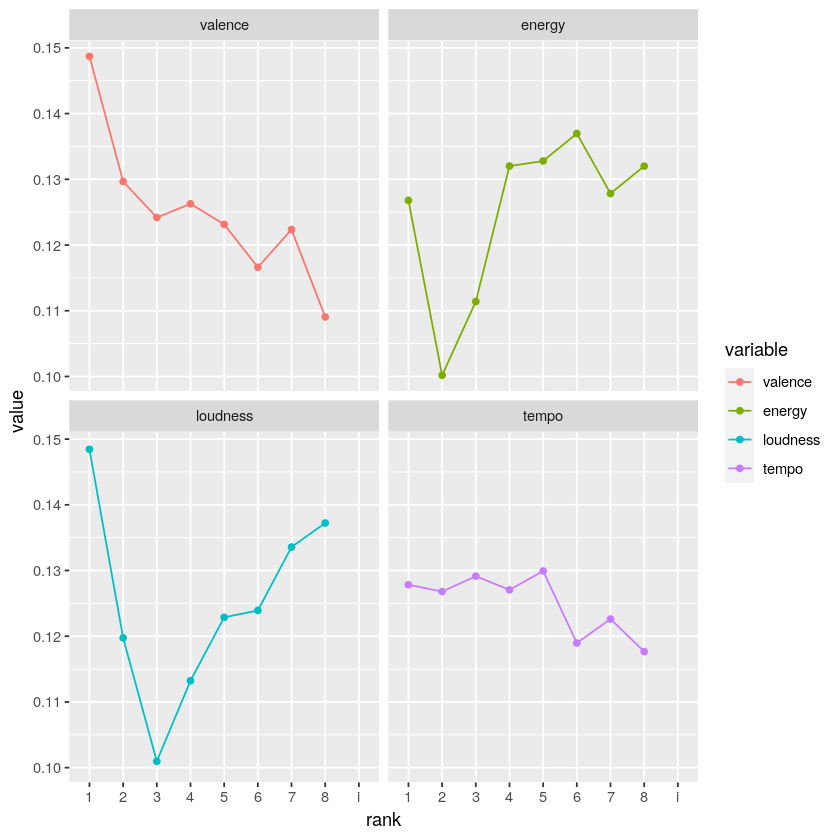

In [16]:
ggplot(data=probmatrix, aes(x=rank, y=value, group = 1)) +
  facet_wrap(~variable)+ geom_line(aes(color=variable, na.rm = TRUE))+
  geom_point(aes(color=variable), na.rm = TRUE)

Loading required package: glm.predict

`summarise()` regrouping output by 'album_id' (override with `.groups` argument)

`summarise()` regrouping output by 'album_id' (override with `.groups` argument)



# weights:  68 (48 variable)
initial  value 15697.011051 
iter  10 value 15483.771181
iter  20 value 15451.996200
iter  30 value 15432.982465
iter  40 value 15424.199367
iter  50 value 15422.836850
final  value 15422.753676 
converged



  1   2   3   4 
939 939 939 933 

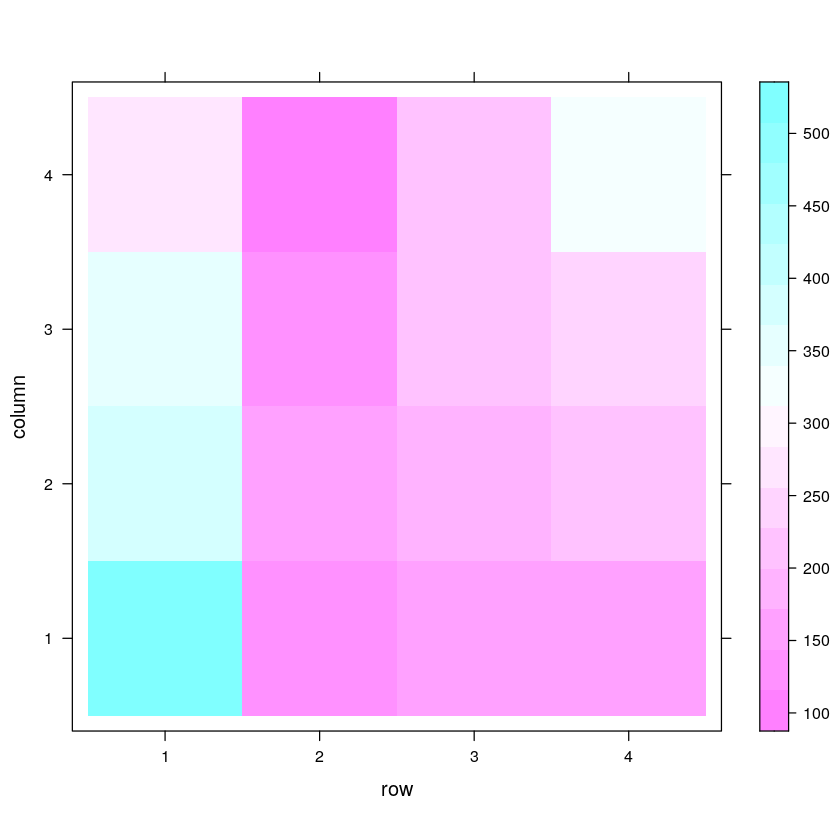

In [138]:
dt_test

album_id,track_number,valence,energy,loudness,tempo,danceability,name
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
008M3KxE8IO39sdTRFeZwn,1,0.575,0.892,-4.734,110.031,0.628,Seja o Que Eu Quiser
008M3KxE8IO39sdTRFeZwn,2,0.944,0.844,-5.478,95.001,0.731,Seja o Que Eu Quiser
008M3KxE8IO39sdTRFeZwn,3,0.725,0.723,-4.468,89.940,0.681,Seja o Que Eu Quiser
008M3KxE8IO39sdTRFeZwn,4,0.608,0.723,-5.651,107.012,0.644,Seja o Que Eu Quiser
008M3KxE8IO39sdTRFeZwn,5,0.728,0.859,-5.399,119.976,0.696,Seja o Que Eu Quiser
008M3KxE8IO39sdTRFeZwn,6,0.813,0.865,-4.767,97.948,0.626,Seja o Que Eu Quiser
008M3KxE8IO39sdTRFeZwn,7,0.680,0.323,-9.087,115.142,0.627,Seja o Que Eu Quiser
008M3KxE8IO39sdTRFeZwn,8,0.957,0.862,-4.829,110.030,0.657,Seja o Que Eu Quiser
00IxPGpvmN2cibMWUEWmUJ,1,0.535,0.259,-14.563,83.959,0.549,Viva


## References
McFee, B., & Lanckriet, G. R. (2011, October). The Natural Language of Playlists. In ISMIR (Vol. 11, pp. 537-541).